# BayesTree

A `BayesTree` is a graphical model that represents the result of multifrontal variable elimination on a `FactorGraph`. It is a tree structure where each node is a 'clique' containing a set of conditional distributions $P(\text{Frontals} | \text{Separator})$.

Each clique k contains a conditional $P(F_k∣S_k)$, where $F_k$ are frontal variables and $S_k$ are separator variables. The joint probability distribution encoded by the Bayes tree is given by the product of all clique conditionals:

$$
P(X) = \prod_k P(F_k | S_k)
$$

Key properties:
*   **Cliques:** Each node (clique) groups variables that are eliminated together.
*   **Frontal Variables:** Variables eliminated within a specific clique.
*   **Separator Variables:** Variables shared between a clique and its parent in the tree. These variables were eliminated higher up in the tree.
*   **Tree Structure:** Represents the dependencies introduced during elimination more compactly than a Bayes net, especially for sparse problems.

Like `FactorGraph` and `BayesNet`, `BayesTree` is templated on the type of conditional/clique (e.g., `GaussianBayesTree`).

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/inference/doc/BayesTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet gtsam-develop

In [9]:
import gtsam
import numpy as np
import graphviz

# We need concrete graph types and elimination to get a BayesTree
from gtsam import GaussianFactorGraph, Ordering, GaussianBayesTree, VariableIndex
from gtsam import symbol_shorthand

X = symbol_shorthand.X
L = symbol_shorthand.L

## Creating a BayesTree (via Elimination)

BayesTrees are typically obtained by performing multifrontal elimination on a `FactorGraph`.

Original Factor Graph:


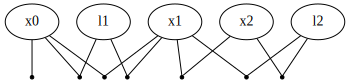

In [10]:
# Create a simple Gaussian Factor Graph
graph = GaussianFactorGraph()
model = gtsam.noiseModel.Isotropic.Sigma(1, 1.0)
graph.add(X(0), -np.eye(1), np.zeros(1), model)           # Prior on x0
graph.add(X(0), -np.eye(1), X(1), np.eye(1), np.zeros(1), model) # x0 -> x1
graph.add(X(1), -np.eye(1), X(2), np.eye(1), np.zeros(1), model) # x1 -> x2
graph.add(L(1), -np.eye(1), X(0), np.eye(1), np.zeros(1), model) # l1 -> x0 (measurement)
graph.add(L(1), -np.eye(1), X(1), np.eye(1), np.zeros(1), model) # l1 -> x1 (measurement)
graph.add(L(2), -np.eye(1), X(1), np.eye(1), np.zeros(1), model) # l2 -> x1 (measurement)
graph.add(L(2), -np.eye(1), X(2), np.eye(1), np.zeros(1), model) # l2 -> x2 (measurement)

print("Original Factor Graph:")
display(graphviz.Source(graph.dot()))

Resulting BayesTree:
: cliques: 2, variables: 5
- p(x1 l2 x2 )
  R = [   1.61245 -0.620174 -0.620174 ]
      [         0   1.27098  -1.08941 ]
      [         0         0  0.654654 ]
  d = [ 0 0 0 ]
  mean: 3 elements
  l2: 0
  x1: 0
  x2: 0
  logNormalizationConstant: -2.46292
  No noise model
| - p(l1 x0  | x1)
  R = [   1.41421 -0.707107 ]
      [         0   1.58114 ]
  S[x1] = [ -0.707107 ]
          [ -0.948683 ]
  d = [ 0 0 ]
  logNormalizationConstant: -1.03316
  No noise model

Visualization:


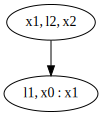

In [12]:
# Eliminate multifrontally using COLAMD ordering
ordering = Ordering.ColamdGaussianFactorGraph(graph)
# Note: Multifrontal typically yields multiple roots if graph is disconnected
bayes_tree = graph.eliminateMultifrontal(ordering)

print("Resulting BayesTree:")
bayes_tree.print()
print("\nVisualization:")
display(graphviz.Source(bayes_tree.dot()))

In [6]:
print(f"BayesTree number of cliques: {bayes_tree.size()}")

BayesTree number of cliques: 2


## Solution and Marginals

Similar to `BayesNet`, `BayesTree` (specifically derived types like `GaussianBayesTree`) provides an `optimize()` method for finding the MLE solution. It also allows for efficient computation of marginals on individual variables or joint marginals on pairs of variables using belief propagation or shortcut evaluation on the tree.

In [7]:
# Optimize to find the MLE solution (for GaussianBayesTree)
mle_solution = bayes_tree.optimize()
print("Optimized Solution (MLE):")
mle_solution.print()

# Compute marginal factor on a single variable (returns a Conditional)
marginal_x1 = bayes_tree.marginalFactor(X(1))
print("\nMarginal Factor on x1:")
marginal_x1.print()

# Compute joint marginal factor graph on two variables
joint_x0_x2 = bayes_tree.joint(X(0), X(2))
print("\nJoint Marginal Factor Graph on (x0, x2):")
joint_x0_x2.print()

Optimized Solution (MLE):
VectorValues: 5 elements
  l1: 0
  l2: 0
  x0: 0
  x1: 0
  x2: 0

Marginal Factor on x1:
GaussianConditional p(x1)
  R = [ 0.774597 ]
  d = [ 0 ]
  mean: 1 elements
  x1: 0
  logNormalizationConstant: -1.17435
  No noise model

Joint Marginal Factor Graph on (x0, x2):

size: 2
factor 0:  p(x0 | x2)
  R = [ 1.32288 ]
  S[x2] = [ -0.566947 ]
  d = [ 0 ]
  logNormalizationConstant: -0.639131
  No noise model
factor 1:  p(x2)
  R = [ 0.654654 ]
  d = [ 0 ]
  mean: 1 elements
  x2: 0
  logNormalizationConstant: -1.34259
  No noise model
